In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os

In [11]:
arma_data = {'braidwood_covid':["./Output_Braidwood_2012_2021_DA_periodic/synthetic.csv", "../data/electricity_markets/PJM_braidwood/"],
              'braidwood_non_covid':["./Output_Braidwood_2012_2019_DA/synthetic.csv", "../data/electricity_markets/PJM_braidwood/"],
              'davis_besse':["./Output_davis_besse_2012_2021_DA/synthetic.csv", "../data/electricity_markets/PJM_davis_besse/"]}


case = "davis_besse"


if case not in arma_data.keys():
  raise KeyError("{}, Case not in dictionary".format(case))
filename = arma_data[case][0]
data_dir = arma_data[case][1]

synthetic_df = pd.read_csv(filename)
tag = filename.split('/')[1][7:]
synthetic_df.head()
#only keep first 4 years of data
synthetic_df = synthetic_df[synthetic_df['Year']<=2021]
# Remove useless data
synthetic_df.drop(columns=['scaling', 'RAVEN_sample_ID','prefix', 'PointProbability', 'ProbabilityWeight'], inplace=True)
synthetic_df.rename({'price':'synthetic price'}, axis=1, inplace=True)
synthetic_df

,hour,Year,synthetic price
0,1.0,2012,18.945111
1,1.0,2013,24.839397
2,1.0,2014,25.031431
3,1.0,2015,28.175170
4,1.0,2016,22.598563
...,...,...,...
332847,8760.0,2017,34.253941
332848,8760.0,2018,18.861993
332849,8760.0,2019,24.810670
332850,8760.0,2020,12.263584


In [12]:
# Get year list from synthetic data
years_list  = synthetic_df.Year.unique()
print(years_list)
files_names = os.listdir(data_dir)
li = []
for f in files_names: 
  if f.endswith('csv'):
    year = int(f.split('_')[0])
    if year in years_list:
      file = data_dir+f
      df = pd.read_csv(file)
      df['Year'] = [year for i in range(len(df))]
      li.append(df)
hist_df = pd.concat(li, axis=0, ignore_index=True)
hist_df.rename({'price':'historical price'}, axis=1,inplace=True)
hist_df

[2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]


,hour,historical price,Year
0,1.0,25.02,2017
1,2.0,24.32,2017
2,3.0,24.17,2017
3,4.0,23.95,2017
4,5.0,24.09,2017
...,...,...,...
87595,8756.0,34.89,2016
87596,8757.0,32.84,2016
87597,8758.0,31.55,2016
87598,8759.0,27.01,2016


Merge historical and synthetic data

In [13]:
sum_df = pd.merge(hist_df, synthetic_df, how='inner')
sum_df

,hour,historical price,Year,synthetic price
0,1.0,25.02,2017,17.344110
1,2.0,24.32,2017,16.454598
2,3.0,24.17,2017,16.652664
3,4.0,23.95,2017,25.471393
4,5.0,24.09,2017,19.732460
...,...,...,...,...
87595,8756.0,34.89,2016,47.863893
87596,8757.0,32.84,2016,40.550654
87597,8758.0,31.55,2016,41.152008
87598,8759.0,27.01,2016,36.122097


In [14]:
# Statistic summary
temp_df = sum_df.drop(columns=['Year','hour'])
stats = dict(temp_df.describe())
#stats_df.append() = temp_df.kurtosis(axis=0)
for k,v in stats.items(): 
  stats[k] = dict(v)
#stats['historical price'] = dict(stats['historical price'])
# Add kurtosis
stats['historical price']['kurtosis'] = float(hist_df['historical price'].kurtosis(axis = 0))
stats['synthetic price']['kurtosis'] = float(synthetic_df['synthetic price'].kurtosis(axis = 0))
# Add skewness
stats['historical price']['skewness'] = float(hist_df['historical price'].skew(axis = 0))
stats['synthetic price']['skewness'] = float(synthetic_df['synthetic price'].skew(axis = 0))
stats_df = pd.DataFrame(stats)
stats_df.to_excel('ARMA_stats.xlsx',sheet_name=tag)
stats_df

,historical price,synthetic price
count,87600.000000,87600.000000
mean,32.977090,32.981867
std,23.072473,23.155333
min,2.270000,2.270000
25%,22.720000,22.646107
50%,28.840000,28.834853
75%,37.000000,37.049300
max,933.680000,933.680000
kurtosis,243.297540,245.526331
skewness,10.856814,10.887985


In [15]:
# Concatenate historic and synthetic prices with a tag
temp_hist = hist_df.drop(columns=['Year', 'hour']).rename({'historical price':'price'}, axis=1)
temp_synth = synthetic_df.drop(columns=['Year', 'hour']).rename({'synthetic price':'price'}, axis=1)
pieces = {'historical': temp_hist, 'synthetic':temp_synth}
prices_df = pd.concat(pieces, names=["type"])
prices_df = prices_df.reset_index(level=0)
prices_df

,type,price
0,historical,25.020000
1,historical,24.320000
2,historical,24.170000
3,historical,23.950000
4,historical,24.090000
...,...,...
332847,synthetic,34.253941
332848,synthetic,18.861993
332849,synthetic,24.810670
332850,synthetic,12.263584


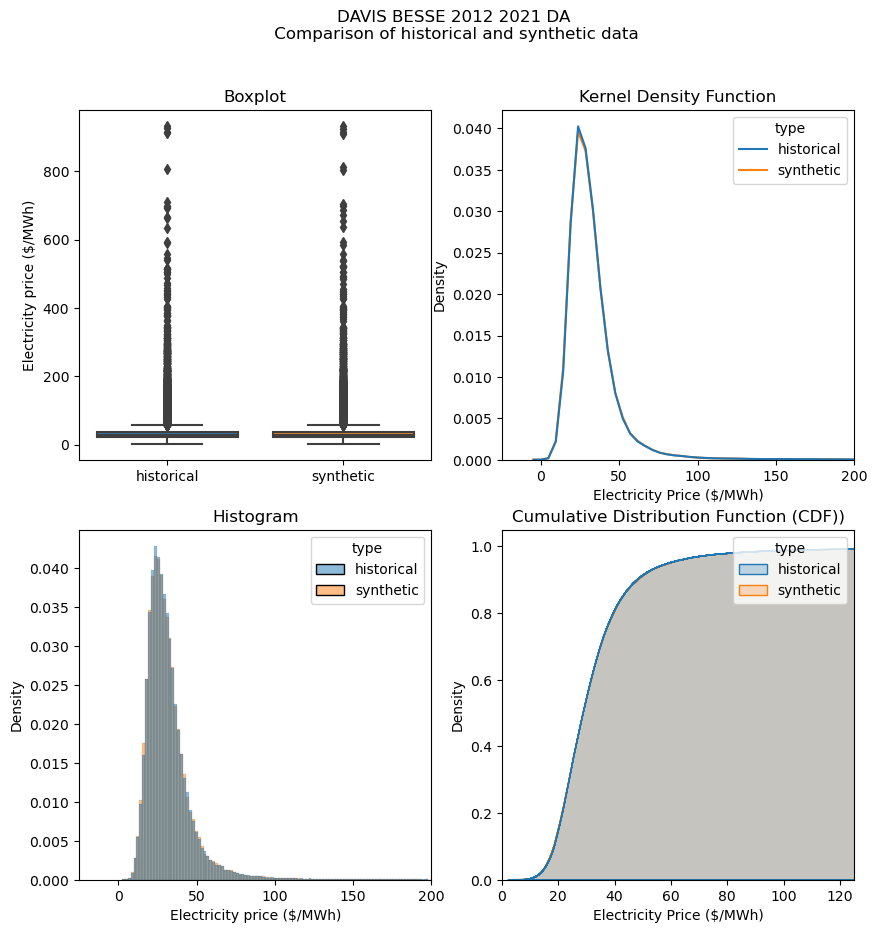

In [16]:
# Plot and save histograms and boxplots
fig, axes = plt.subplots(2,2,figsize =(10,10))

title = ' '.join(tag.split('_')).upper()+'\n Comparison of historical and synthetic data'
fig.suptitle(title)

sns.boxplot(ax = axes[0,0],data=prices_df, x='type', y='price')
axes[0,0].set_title('Boxplot')
axes[0,0].set_ylabel('Electricity price ($/MWh)')
axes[0,0].set_xlabel('')

sns.histplot(ax = axes[1,0], data=prices_df, x='price', hue='type', bins=500, stat='density', common_norm=False)
axes[1,0].set_title('Histogram')
axes[1,0].set_xlabel('Electricity price ($/MWh)')
axes[1,0].set_xlim(-25,200)

sns.kdeplot(ax = axes[0,1], x='price', data=prices_df, hue='type',common_norm=False)
axes[0,1].set_title('Kernel Density Function')
axes[0,1].set_xlabel('Electricity Price ($/MWh)')
axes[0,1].set_xlim(-25,200)

sns.histplot(ax = axes[1,1], data=prices_df, x='price', hue='type', bins=len(prices_df), stat='density', element='step', fill=True,cumulative=True, common_norm=False)
axes[1,1].set_title('Cumulative Distribution Function (CDF))')
axes[1,1].set_xlabel('Electricity Price ($/MWh)')
axes[1,1].set_xlim(0,125)

fig.savefig(tag+'_comparison_plots.png')

